In [1]:
from memo import memo
import jax
import jax.numpy as np

N = 10  # number of possible proposals
Proposal = np.arange(N + 1)
Decision = np.array([0, 1])  # accept, reject

@jax.jit
def payout_offerer(prop, dec):
    return np.array([
        N - prop,  # if receiver accepts
        0          # if receiver rejects
    ])[dec]

@jax.jit
def payout_receiver(prop, dec):
    return np.array([
        prop,  # if receiver accepts
        0      # if receiver rejects
    ])[dec]

@memo  # probability that receiver accepts proposal
def receiver[prop: Proposal, dec: Decision]():
    receiver: knows(prop)
    receiver: chooses(dec in Decision, wpp=exp(2.0 * payout_receiver(prop, dec)))
    return Pr[ receiver.dec == dec ]

@memo  # probability that offerer proposes proposal
def offerer[prop: Proposal]():
    offerer: chooses(prop in Proposal, wpp=exp(2. * imagine[
        receiver: knows(prop),
        receiver: chooses(dec in Decision, wpp=receiver[prop, dec]()),
        E[ payout_offerer(prop, receiver.dec) ]
    ]))
    return E[ offerer.prop == prop ]

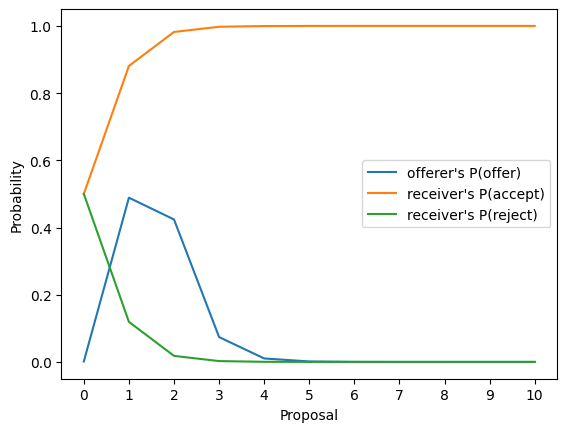

In [2]:
from matplotlib import pyplot as plt

plt.plot(offerer(), label="offerer's P(offer)")
plt.plot(receiver()[:, 0], label="receiver's P(accept)")
plt.plot(receiver()[:, 1], label="receiver's P(reject)")

plt.xlabel('Proposal')
plt.xticks(Proposal)
plt.ylabel('Probability')

plt.legend()